In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
directory = "/content/drive/MyDrive/MELD.Raw"
files = os.listdir(directory)
print(files)

['dev_sent_emo.csv', 'test_sent_emo.csv', 'README.txt', '._train_splits', 'dev.tar.gz', 'train']


extracting the test features

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
from tqdm import tqdm

# Define paths
data_path = "/content/drive/MyDrive/MELD.Raw/train/train_sent_emo.csv"  # Adjust if necessary

# Load dataset
df = pd.read_csv(data_path)
sentences = df['Utterance'].tolist()  # Assuming 'Utterance' contains text

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # Set to evaluation mode

# Function to extract BERT embeddings
def extract_bert_features(sentences):
    features = []

    with torch.no_grad():
        for sentence in tqdm(sentences, desc="Extracting Features"):
            inputs = tokenizer(sentence, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token embedding
            features.append(cls_embedding)

    return features

# Extract features
bert_features = extract_bert_features(sentences)

# Convert to DataFrame and save
features_df = pd.DataFrame(bert_features)
features_df.to_csv("/content/drive/MyDrive/MELD.Raw/train/bert_features.csv", index=False)

print("✅ BERT features extracted and saved successfully!")


Extracting Features: 100%|██████████| 9989/9989 [1:41:42<00:00,  1.64it/s]


✅ BERT features extracted and saved successfully!


balencing the text data

In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
print(df.columns)


Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Season',
       'Episode', 'StartTime', 'EndTime', 'Frames_Path'],
      dtype='object')


In [ ]:
import os
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import torch

# Disable Weights & Biases (wandb) logging
os.environ["WANDB_DISABLED"] = "true"

# Step 1: Load the dataset
file_path = "/content/drive/MyDrive/MELD.Raw/train/train_sent_emo.csv"
df = pd.read_csv(file_path)

# Print column names to verify
print(df.columns)

# Rename columns if necessary
df.rename(columns={'Utterance': 'sentence', 'Emotion': 'emotion'}, inplace=True)

# Ensure required columns exist
if 'sentence' not in df.columns or 'emotion' not in df.columns:
    raise ValueError("Required columns are missing in the dataset")

# Select only the required columns
df = df[['sentence', 'emotion']]

# Encode labels
emotion_labels = ['neutral', 'surprise', 'anger', 'joy', 'sadness', 'fear', 'disgust']
label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}
df['label'] = df['emotion'].map(label_map)

# Step 2: Balance the Dataset
# Check class distribution
print("Original Class Distribution:\n", df['emotion'].value_counts())

# Find the maximum class count
max_count = df['emotion'].value_counts().max()

# Oversample minority classes
balanced_df = pd.DataFrame()
for emotion in emotion_labels:
    subset = df[df['emotion'] == emotion]
    resampled_subset = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_df = pd.concat([balanced_df, resampled_subset])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print("Balanced Class Distribution:\n", balanced_df['emotion'].value_counts())

# Step 3: Split the dataset into training and testing sets
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Step 4: Tokenization and Dataset Preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Step 5: Prepare the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotion_labels))

# Step 6: Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Step 7: Define the Trainer and start training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

# Step 8: Evaluate the model
results = trainer.evaluate()
print(results)

# Step 9: Save the model
model.save_pretrained("emotion_classifier_model")
tokenizer.save_pretrained("emotion_classifier_model")


Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Season',
       'Episode', 'StartTime', 'EndTime', 'Frames_Path'],
      dtype='object')
Original Class Distribution:
 emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64
Balanced Class Distribution:
 emotion
surprise    4710
sadness     4710
anger       4710
neutral     4710
joy         4710
fear        4710
disgust     4710
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/26376 [00:00<?, ? examples/s]

Map:   0%|          | 0/6594 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-1-147bfb37676d>:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


traing for test using beert models

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.303500,1.249015
2,1.098600,1.165425
3,0.823000,1.167923


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

     neutral       0.78      0.88      0.83       105
    surprise       0.47      0.37      0.41        19
       anger       0.48      0.34      0.40        29
         joy       0.41      0.83      0.55        23
     sadness       0.00      0.00      0.00        16
        fear       0.00      0.00      0.00         3
     disgust       0.00      0.00      0.00         5

    accuracy                           0.64       200
   macro avg       0.31      0.35      0.31       200
weighted avg       0.57      0.64      0.59       200



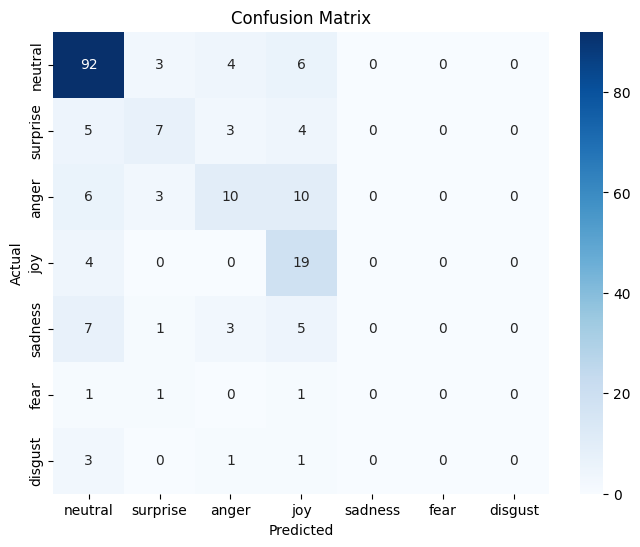

In [ ]:
# ✅ Install dependencies (Run separately if needed)
# !pip install transformers datasets torch seaborn matplotlib scikit-learn accelerate

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, ClassLabel

# ✅ Load dataset (Adjust path if needed)
data_path = "/content/drive/MyDrive/MELD.Raw/train/train_sent_emo.csv"
df = pd.read_csv(data_path, usecols=['Utterance', 'Emotion'])  # Load only necessary columns

# ✅ Handle missing or empty utterances
df.dropna(inplace=True)
df = df[df['Utterance'].str.strip() != ""]  # Remove empty strings

# ✅ Take only 1000 samples for faster training
df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# ✅ Encode emotion labels (ClassLabel handles dtype issues)
emotion_labels = list(df['Emotion'].unique())
label_feature = ClassLabel(num_classes=len(emotion_labels), names=emotion_labels)
df['Emotion'] = df['Emotion'].map({label: idx for idx, label in enumerate(emotion_labels)})

# ✅ Train-Test Split (80-20)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Utterance'].tolist(), df['Emotion'].tolist(), test_size=0.2, random_state=42
)

# ✅ Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Tokenization function with reduced sequence length (faster processing)
def tokenize_function(examples):
    return tokenizer(examples["Utterance"], padding="max_length", truncation=True, max_length=32)

# ✅ Convert to Hugging Face Dataset format with explicit `label` type
train_dataset = Dataset.from_pandas(pd.DataFrame({"Utterance": train_texts, "label": train_labels}))
test_dataset = Dataset.from_pandas(pd.DataFrame({"Utterance": test_texts, "label": test_labels}))

# ✅ Tokenize datasets in batches (parallel processing)
train_dataset = train_dataset.map(tokenize_function, batched=True).remove_columns(["Utterance"])
test_dataset = test_dataset.map(tokenize_function, batched=True).remove_columns(["Utterance"])

# ✅ Explicitly set label column to avoid dtype issues
train_dataset = train_dataset.cast_column("label", label_feature)
test_dataset = test_dataset.cast_column("label", label_feature)

# ✅ Load pre-trained BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(emotion_labels)).to(device)

# ✅ Training arguments (Optimized for Stability)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Lower batch size for memory efficiency
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,  # Reduce logging frequency
    report_to="none",  # Disable unnecessary logging to WandB
    fp16=True,  # Enable mixed precision for memory efficiency
    eval_accumulation_steps=2,  # Prevents OOM during evaluation
)

# ✅ Trainer for fine-tuning BERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# ✅ Train the model
trainer.train()

# ✅ Evaluate the model
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# ✅ Classification Report
print("Classification Report:\n", classification_report(test_labels, preds, target_names=emotion_labels))

# ✅ Confusion Matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


after balancing traing


🔹 Original Class Distribution:
 emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64

✅ Balanced Class Distribution:
 emotion
surprise    4710
sadness     4710
anger       4710
neutral     4710
joy         4710
fear        4710
disgust     4710
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/26376 [00:00<?, ? examples/s]

Map:   0%|          | 0/6594 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-3-846a2de00284>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Training BERT model on the balanced dataset...


Epoch,Training Loss,Validation Loss
1,0.932300,0.428357
2,0.293900,0.276705
3,0.161100,0.281349



🔍 Evaluation Results: {'eval_loss': 0.28134894371032715, 'eval_runtime': 46.1084, 'eval_samples_per_second': 143.011, 'eval_steps_per_second': 2.256, 'epoch': 3.0}

📊 Classification Report:
               precision    recall  f1-score   support

     neutral       0.92      0.78      0.85       947
    surprise       0.89      0.94      0.91       909
       anger       0.92      0.93      0.92       964
         joy       0.89      0.90      0.90      1021
     sadness       0.94      0.96      0.95       920
        fear       0.96      0.99      0.98       893
     disgust       0.98      0.99      0.99       940

    accuracy                           0.93      6594
   macro avg       0.93      0.93      0.93      6594
weighted avg       0.93      0.93      0.93      6594



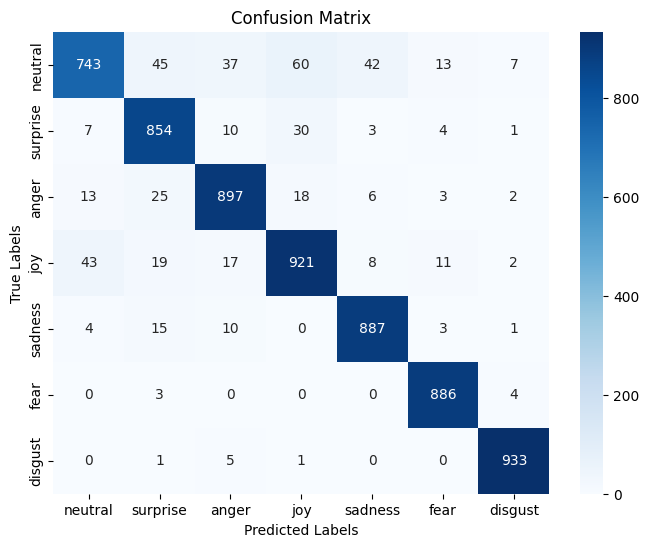

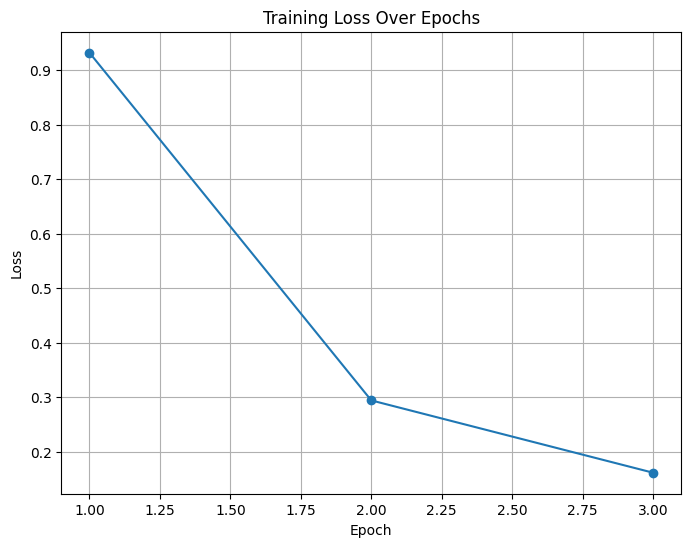


✅ Model and tokenizer saved successfully!


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Disable WandB to avoid unwanted logs
os.environ["WANDB_DISABLED"] = "true"

# ✅ Load the dataset
file_path = "/content/drive/MyDrive/MELD.Raw/train/train_sent_emo.csv"
df = pd.read_csv(file_path)

# ✅ Rename columns if needed
df.rename(columns={'Utterance': 'sentence', 'Emotion': 'emotion'}, inplace=True)

# ✅ Select relevant columns
df = df[['sentence', 'emotion']]

# ✅ Encode labels
emotion_labels = ['neutral', 'surprise', 'anger', 'joy', 'sadness', 'fear', 'disgust']
label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}
df['label'] = df['emotion'].map(label_map)

# ✅ Balance the Dataset
print("\n🔹 Original Class Distribution:\n", df['emotion'].value_counts())

# Oversample minority classes
max_count = df['emotion'].value_counts().max()
balanced_df = pd.concat([
    resample(df[df['emotion'] == emo], replace=True, n_samples=max_count, random_state=42)
    for emo in emotion_labels
]).sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Check balanced class distribution
print("\n✅ Balanced Class Distribution:\n", balanced_df['emotion'].value_counts())

# ✅ Split dataset
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# ✅ Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# ✅ Load BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotion_labels))

# ✅ Define Training Arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

print("\n🚀 Training BERT model on the balanced dataset...")
trainer.train()

# ✅ Evaluate Model
results = trainer.evaluate()
print("\n🔍 Evaluation Results:", results)

# ✅ Get Predictions for Test Set
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true_labels = test_df['label'].values

# ✅ Classification Report
print("\n📊 Classification Report:\n", classification_report(true_labels, preds, target_names=emotion_labels))

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Plot Training Loss
logs = trainer.state.log_history
epochs = [entry['epoch'] for entry in logs if 'loss' in entry]
losses = [entry['loss'] for entry in logs if 'loss' in entry]

plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()

# ✅ Save Model
model.save_pretrained("bert_emotion_classifier")
tokenizer.save_pretrained("bert_emotion_classifier")
print("\n✅ Model and tokenizer saved successfully!")


In [ ]:
import pandas as pd
import os
import re

# Define paths
csv_file = "/content/train_sent_emo.csv"
video_folder = "/content/drive/MyDrive/MELD.Raw/train/frames"

# Load the CSV file
df = pd.read_csv(csv_file)

# Ensure column names are correctly formatted
df.columns = df.columns.str.strip()  # Remove extra spaces if any

# Convert to integers (if they exist)
if "Dialogue_ID" in df.columns and "Utterance_ID" in df.columns:
    df["Dialogue_ID"] = pd.to_numeric(df["Dialogue_ID"], errors="coerce").astype("Int64")
    df["Utterance_ID"] = pd.to_numeric(df["Utterance_ID"], errors="coerce").astype("Int64")
else:
    raise KeyError("Columns 'Dialogue_ID' and 'Utterance_ID' are missing from the CSV file.")

# Function to extract IDs
def extract_ids(filename):
    match = re.search(r'dia(\d+)_utt(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2)), os.path.join(video_folder, filename)
    return None, None, None

# Process all frame directories (not MP4 files)
file_data = []
for filename in os.listdir(video_folder):
    if "dia" in filename and "utt" in filename:  # Match only relevant files/folders
        dialogue_id, utterance_id, file_path = extract_ids(filename)
        if dialogue_id is not None and utterance_id is not None:
            file_data.append({"Dialogue_ID": dialogue_id, "Utterance_ID": utterance_id, "File_Path": file_path})

# Debugging: Print extracted data
if not file_data:
    print("No matching directories found! Check filenames in:", video_folder)
else:
    print(f"Extracted {len(file_data)} directories.")

# Create DataFrame from extracted data
file_df = pd.DataFrame(file_data)

# If file_df is empty, print an error and exit
if file_df.empty:
    raise ValueError("No valid directories were extracted. Check filename format.")

# Convert extracted IDs to integers for safe merging
file_df["Dialogue_ID"] = file_df["Dialogue_ID"].astype("Int64")
file_df["Utterance_ID"] = file_df["Utterance_ID"].astype("Int64")

# Merge with existing CSV
df = df.merge(file_df, on=["Dialogue_ID", "Utterance_ID"], how="left")

# Save the updated CSV
df.to_csv(csv_file, index=False)

print("CSV file updated successfully!")


Extracted 1402 directories.
CSV file updated successfully!


In [ ]:
print(df)

      Sr No.                                          Utterance  \
0          1  also I was the point person on my companys tr...   
1          2                   You mustve had your hands full.   
2          3                            That I did. That I did.   
3          4      So lets talk a little bit about your duties.   
4          5                             My duties?  All right.   
...      ...                                                ...   
9984   10474                                         You or me?   
9985   10475  I got it. Uh, Joey, women don't have Adam's ap...   
9986   10476               You guys are messing with me, right?   
9987   10477                                              Yeah.   
9988   10478  That was a good one. For a second there, I was...   

              Speaker   Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  \
0            Chandler   neutral   neutral            0             0       8   
1     The Interviewer   neutral   n

In [ ]:
!pip install torch torchvision transformers pandas numpy scikit-learn dgl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

1. Load Dataset
python
Copy
Edit


In [ ]:
!pip install torchdata

In [ ]:
!pip uninstall -y torchdata # uninstall the current version
!pip install torchdata==0.6.0 # Install the version that contains torchdata.datapipes

Found existing installation: torchdata 0.11.0
Uninstalling torchdata-0.11.0:
  Successfully uninstalled torchdata-0.11.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --force-reinstall dgl[graphbolt]

  Using cached dgl-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (553 bytes)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:00
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.0 MB/s eta 0:00:00
  Using cached torchdata-0.11.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.

In [ ]:
# Check files in the directory
!ls /usr/local/lib/python3.11/dist-packages/dgl/graphbolt/

# Example command to install a specific CUDA toolkit version:
!apt-get install cuda-toolkit-11-6  # Replace with your actual CUDA version

# Reinstall DGL Graphbolt
!pip install --force-reinstall dgl[graphbolt]

base.py		    itemset.py			   minibatch_transformer.py
dataloader.py	    libgraphbolt_pytorch_2.0.0.so  negative_sampler.py
dataset.py	    libgraphbolt_pytorch_2.0.1.so  __pycache__
feature_fetcher.py  libgraphbolt_pytorch_2.1.0.so  sampled_subgraph.py
feature_store.py    libgraphbolt_pytorch_2.1.1.so  sampling_graph.py
impl		    libgraphbolt_pytorch_2.1.2.so  subgraph_sampler.py
__init__.py	    libgraphbolt_pytorch_2.2.0.so  utils.py
internal	    libgraphbolt_pytorch_2.2.1.so
item_sampler.py     minibatch.py
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package cuda-toolkit-11-6
  Using cached dgl-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (553 bytes)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata 

In [ ]:
!pip install dgl==1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 28.2 MB/s eta 0:00:00
  Attempting uninstall: dgl
    Found existing installation: dgl 2.1.0
    Uninstalling dgl-2.1.0:
      Successfully uninstalled dgl-2.1.0


In [ ]:
pip install transformers torchvision torch-scatter torch-geometric scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=9a03ab49ec372df5c828b228a63e0f80691fe97ee031e325c66c10a3062ccb72
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 5.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00


In [ ]:
!pip install wandb

traing frames with lstm

In [ ]:
import pandas as pd
import os
import shutil

# Load CSV
df = pd.read_csv("/content/train_sent_emo.csv")

# Filter only valid folders
df = df.dropna(subset=['File_Path'])
df = df[df['File_Path'].apply(lambda x: os.path.isdir(x))]

# Balance the dataset
min_count = df['Emotion'].value_counts().min()
balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Save balanced CSV
balanced_df.to_csv("/content/balanced_sent_emo.csv", index=False)


<ipython-input-7-f75a3750c1fc>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet18
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=True).to(device)
model.eval()
extractor = torch.nn.Sequential(*list(model.children())[:-1])  # remove FC

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_frame_features(folder, num_frames=5):
    features = []
    frames = sorted(os.listdir(folder))[:num_frames]
    for f in frames:
        path = os.path.join(folder, f)
        image = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = extractor(image).squeeze().cpu()
            features.append(feat)
    if features:
        return torch.stack(features)  # Shape: [num_frames, feature_dim]
    else:
        return torch.zeros((num_frames, 512))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import Dataset
emotion_map = {emo: i for i, emo in enumerate(balanced_df['Emotion'].unique())}
class FrameLSTMDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        feature_seq = extract_frame_features(row['File_Path'])
        label = emotion_map[row['Emotion']]
        return feature_seq, torch.tensor(label)


In [ ]:
import torch.nn as nn

class EmotionLSTM(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, num_layers=1, num_classes=7):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])


Epoch 1, Loss: 2.0170, Accuracy: 13.49%
Epoch 2, Loss: 1.8617, Accuracy: 24.21%
Epoch 3, Loss: 1.7649, Accuracy: 38.49%
Epoch 4, Loss: 1.5659, Accuracy: 49.21%
Epoch 5, Loss: 1.3609, Accuracy: 55.56%
Epoch 6, Loss: 1.1439, Accuracy: 64.68%
Epoch 7, Loss: 0.9495, Accuracy: 72.62%
Epoch 8, Loss: 0.7381, Accuracy: 81.35%
Epoch 9, Loss: 0.4784, Accuracy: 92.46%
Epoch 10, Loss: 0.3140, Accuracy: 95.63%
Epoch 11, Loss: 0.1893, Accuracy: 98.41%
Epoch 12, Loss: 0.1065, Accuracy: 98.81%
Epoch 13, Loss: 0.0837, Accuracy: 99.60%
Epoch 14, Loss: 0.0671, Accuracy: 98.41%
Epoch 15, Loss: 0.0513, Accuracy: 99.60%
Epoch 16, Loss: 0.0457, Accuracy: 98.81%
Epoch 17, Loss: 0.0437, Accuracy: 99.21%
Epoch 18, Loss: 0.0379, Accuracy: 99.60%
Epoch 19, Loss: 0.0379, Accuracy: 99.60%
Epoch 20, Loss: 0.0333, Accuracy: 98.41%
Epoch 21, Loss: 0.0313, Accuracy: 98.81%
Epoch 22, Loss: 0.0282, Accuracy: 99.60%
Epoch 23, Loss: 0.0220, Accuracy: 99.60%
Epoch 24, Loss: 0.0157, Accuracy: 99.60%
Epoch 25, Loss: 0.0154, A

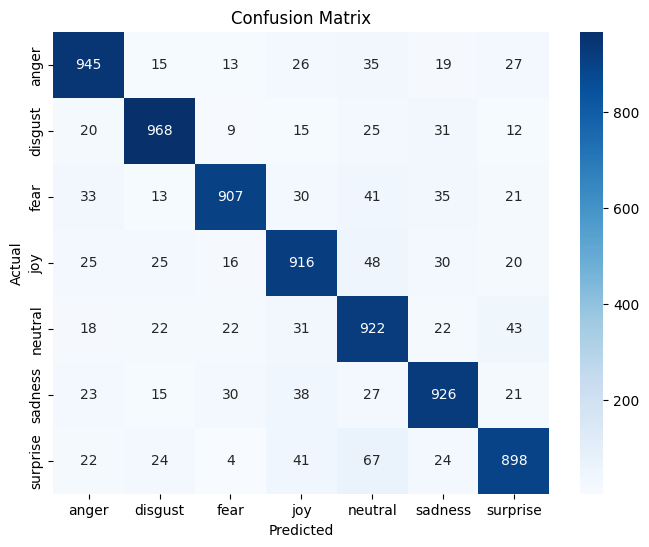

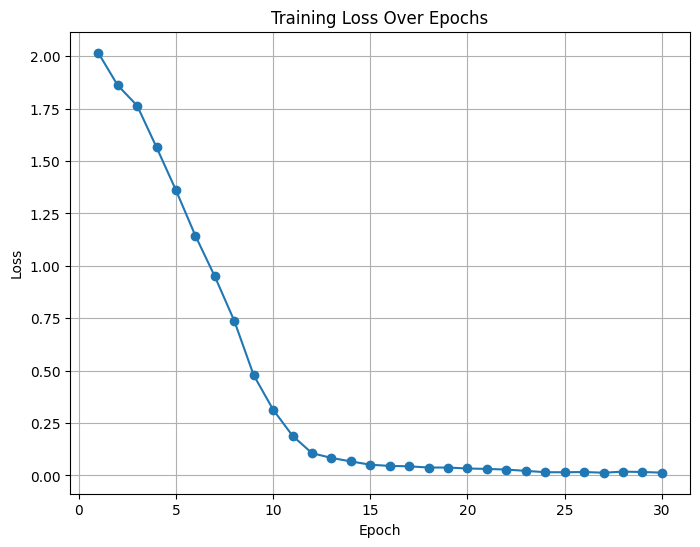

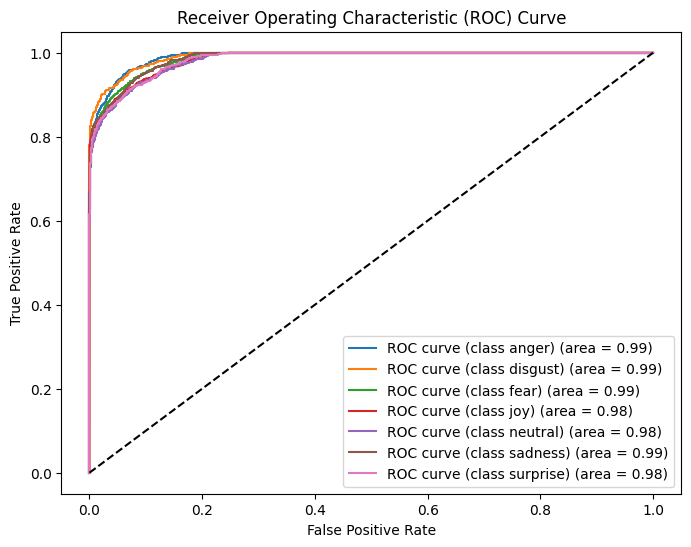

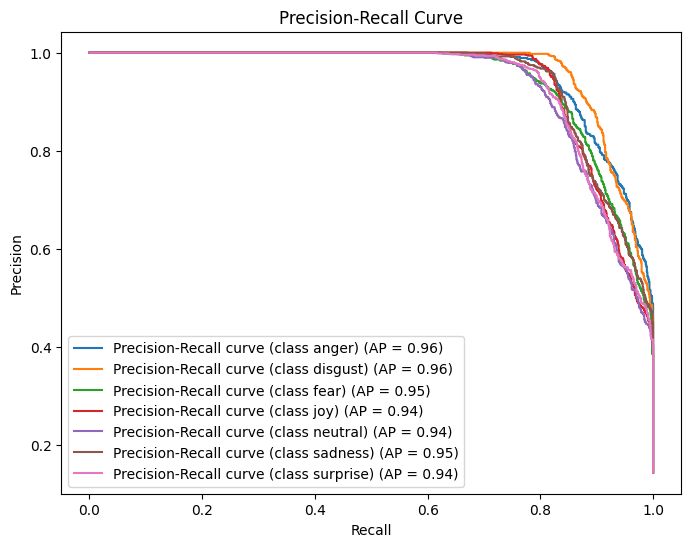

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

# Function to plot ROC curve
def plot_roc_curve(all_labels, all_preds_prob, num_classes, emotion_map):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_preds_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {list(emotion_map.keys())[i]}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(all_labels, all_preds_prob, num_classes, emotion_map):
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(all_labels == i, all_preds_prob[:, i])
        average_precision[i] = average_precision_score(all_labels == i, all_preds_prob[:, i])

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], label=f'Precision-Recall curve (class {list(emotion_map.keys())[i]}) (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Assuming balanced_df and FrameLSTMDataset are defined elsewhere in your code
dataset = FrameLSTMDataset(balanced_df)

def collate_fn(batch):
    features = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    return features_padded, labels

loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model = EmotionLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

all_preds = []
all_labels = []
all_preds_prob = []  # to store probabilities for ROC and PR curves
losses = []

for epoch in range(30):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        # Save probabilities for ROC and Precision-Recall curves
        all_preds_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

        total_samples += y.size(0)
        correct_predictions += (predicted == y).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    epoch_loss = total_loss / len(loader)
    accuracy = 100 * correct_predictions / total_samples
    losses.append(epoch_loss)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(emotion_map.keys())))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(emotion_map.keys()), yticklabels=list(emotion_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Training Loss over Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

# Once training is finished, plot the ROC and Precision-Recall curves
num_classes = len(emotion_map)  # Number of classes
all_labels = np.array(all_labels)
all_preds_prob = np.array(all_preds_prob)

# Plot ROC and Precision-Recall curves
plot_roc_curve(all_labels, all_preds_prob, num_classes, emotion_map)
plot_precision_recall_curve(all_labels, all_preds_prob, num_classes, emotion_map)


finding missclassifier for lSTM

traing with LSTM+ATTENTION layers

Total usable samples: 1402
Device: cuda


<ipython-input-2-735a0d147842>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1

Epoch 1, Loss: 1.9870, Accuracy: 11.90%
Epoch 2, Loss: 1.8384, Accuracy: 28.57%
Epoch 3, Loss: 1.7164, Accuracy: 46.43%
Epoch 4, Loss: 1.5162, Accuracy: 54.37%
Epoch 5, Loss: 1.3111, Accuracy: 60.71%
Epoch 6, Loss: 1.0506, Accuracy: 66.67%
Epoch 7, Loss: 0.8148, Accuracy: 79.37%
Epoch 8, Loss: 0.5648, Accuracy: 86.51%
Epoch 9, Loss: 0.4567, Accuracy: 88.49%
Epoch 10, Loss: 0.3115, Accuracy: 94.05%
Epoch 11, Loss: 0.1905, Accuracy: 97.62%
Epoch 12, Loss: 0.1733, Accuracy: 96.03%
Epoch 13, Loss: 0.1022, Accuracy: 99.60%
Epoch 14, Loss: 0.0685, Accuracy: 99.60%
Epoch 15, Loss: 0.0732, Accuracy: 98.02%
Epoch 16, Loss: 0.0513, Accuracy: 98.81%
Epoch 17, Loss: 0.0464, Accuracy: 98.41%
Epoch 18, Loss: 0.0300, Accuracy: 99.60%
Epoch 19, Loss: 0.0238, Accuracy: 99.60%
Epoch 20, Loss: 0.0200, Accuracy: 99.21%
Epoch 21, Loss: 0.0208, Accuracy: 99.21%
Epoch 22, Loss: 0.0252, Accuracy: 99.21%
Epoch 23, Loss: 0.0220, Accuracy: 99.21%
Epoch 24, Loss: 0.0193, Accuracy: 99.21%
Epoch 25, Loss: 0.0144, A

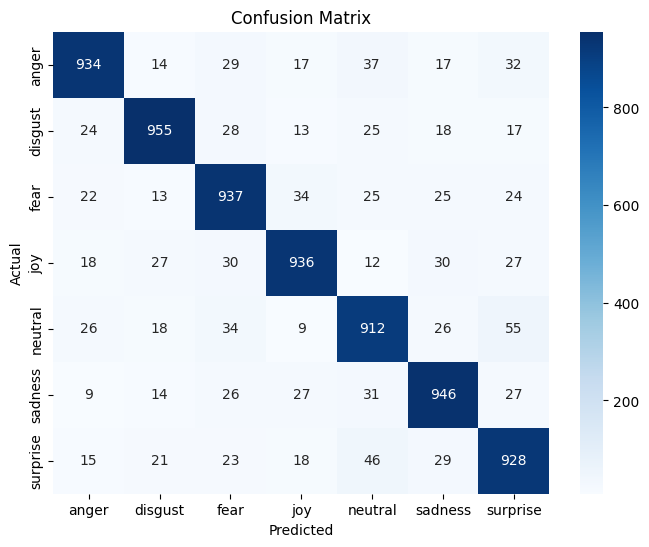

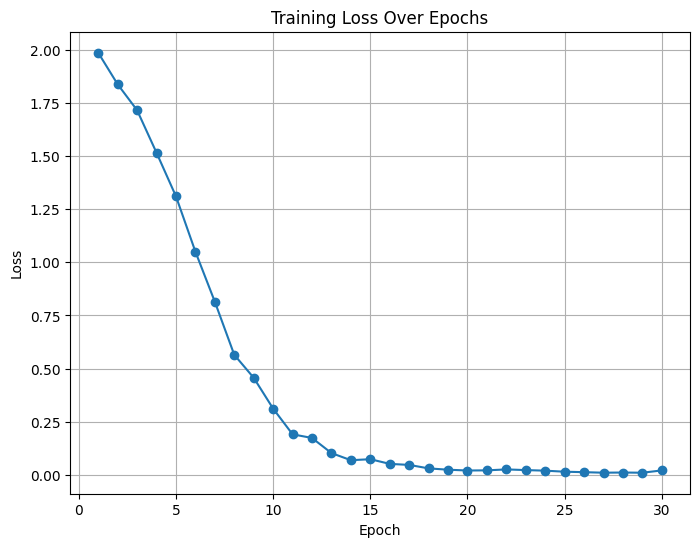

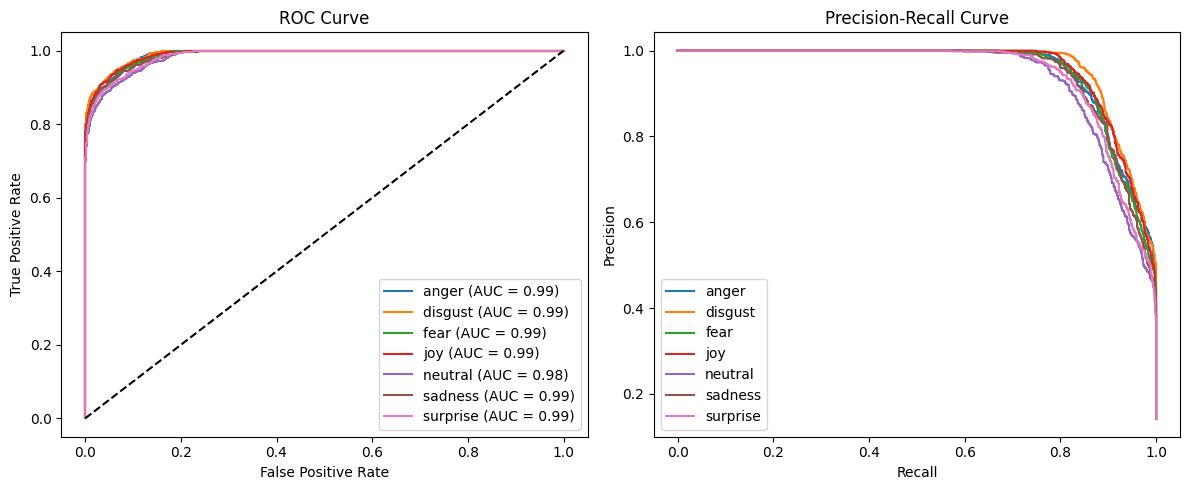

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as T
from torchvision.models import resnet18
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Data Preparation ===
df = pd.read_csv("/content/train_sent_emo.csv")
df = df.dropna(subset=['File_Path'])
df = df[df['File_Path'].apply(lambda x: os.path.isdir(x))]
print("Total usable samples:", len(df))

min_count = df['Emotion'].value_counts().min()
balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
balanced_df.to_csv("/content/balanced_sent_emo.csv", index=False)

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# === Feature Extractor ===
model = resnet18(pretrained=True).to(device)
model.eval()
extractor = torch.nn.Sequential(*list(model.children())[:-1])

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_frame_features(folder, num_frames=5):
    features = []
    frames = sorted(os.listdir(folder), key=lambda x: int(x.split('_')[-1].split('.')[0]))[:num_frames]
    for f in frames:
        path = os.path.join(folder, f)
        image = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = extractor(image).squeeze().cpu()
            features.append(feat)
    if features:
        return torch.stack(features)
    else:
        return torch.zeros((num_frames, 512))

# === Dataset and Label Map ===
emotion_map = {emo: i for i, emo in enumerate(balanced_df['Emotion'].unique())}
class FrameLSTMDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        feature_seq = extract_frame_features(row['File_Path'])
        label = emotion_map[row['Emotion']]
        return feature_seq, torch.tensor(label)

# === Model ===
class EmotionLSTMAttn(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, num_layers=1, num_classes=7):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out

# === Collate Function ===
def collate_fn(batch):
    features = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    return features_padded, labels

# === Training Setup ===
dataset = FrameLSTMDataset(balanced_df)
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model = EmotionLSTMAttn(num_classes=len(emotion_map)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# === Training Loop ===
all_preds = []
all_labels = []
all_probs = []
losses = []

for epoch in range(30):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        total_samples += y.size(0)
        correct_predictions += (predicted == y).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    epoch_loss = total_loss / len(loader)
    accuracy = 100 * correct_predictions / total_samples
    losses.append(epoch_loss)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# === Evaluation ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(emotion_map.keys())))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(emotion_map.keys()), yticklabels=list(emotion_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === Loss Curve ===
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

# === ROC and Precision-Recall Curves ===
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

plt.figure(figsize=(12, 5))

# ROC Curves
plt.subplot(1, 2, 1)
for i in range(len(emotion_map)):
    fpr, tpr, _ = roc_curve(all_labels_np == i, all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{list(emotion_map.keys())[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curves
plt.subplot(1, 2, 2)
for i in range(len(emotion_map)):
    precision, recall, _ = precision_recall_curve(all_labels_np == i, all_probs_np[:, i])
    plt.plot(recall, precision, label=list(emotion_map.keys())[i])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


finding miss classifier

<ipython-input-5-3b28cef51998>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1

Epoch 1, Loss: 1.9973, Accuracy: 10.71%
Epoch 2, Loss: 1.8606, Accuracy: 28.97%
Epoch 3, Loss: 1.7266, Accuracy: 48.81%
Epoch 4, Loss: 1.5286, Accuracy: 50.40%
Epoch 5, Loss: 1.3162, Accuracy: 61.90%
Epoch 6, Loss: 1.0526, Accuracy: 67.06%
Epoch 7, Loss: 0.7926, Accuracy: 80.95%
Epoch 8, Loss: 0.5719, Accuracy: 86.90%
Epoch 9, Loss: 0.3818, Accuracy: 94.84%
Epoch 10, Loss: 0.2444, Accuracy: 95.63%
Epoch 11, Loss: 0.1629, Accuracy: 98.81%
Epoch 12, Loss: 0.1140, Accuracy: 98.81%
Epoch 13, Loss: 0.0765, Accuracy: 98.81%
Epoch 14, Loss: 0.0699, Accuracy: 99.60%
Epoch 15, Loss: 0.0661, Accuracy: 98.81%
Epoch 16, Loss: 0.0588, Accuracy: 99.21%
Epoch 17, Loss: 0.0550, Accuracy: 99.21%
Epoch 18, Loss: 0.0480, Accuracy: 99.21%
Epoch 19, Loss: 0.0389, Accuracy: 98.41%
Epoch 20, Loss: 0.0386, Accuracy: 99.21%
Epoch 21, Loss: 0.0236, Accuracy: 99.21%
Epoch 22, Loss: 0.0281, Accuracy: 98.81%
Epoch 23, Loss: 0.0194, Accuracy: 99.60%
Epoch 24, Loss: 0.0157, Accuracy: 99.60%
Epoch 25, Loss: 0.0148, A

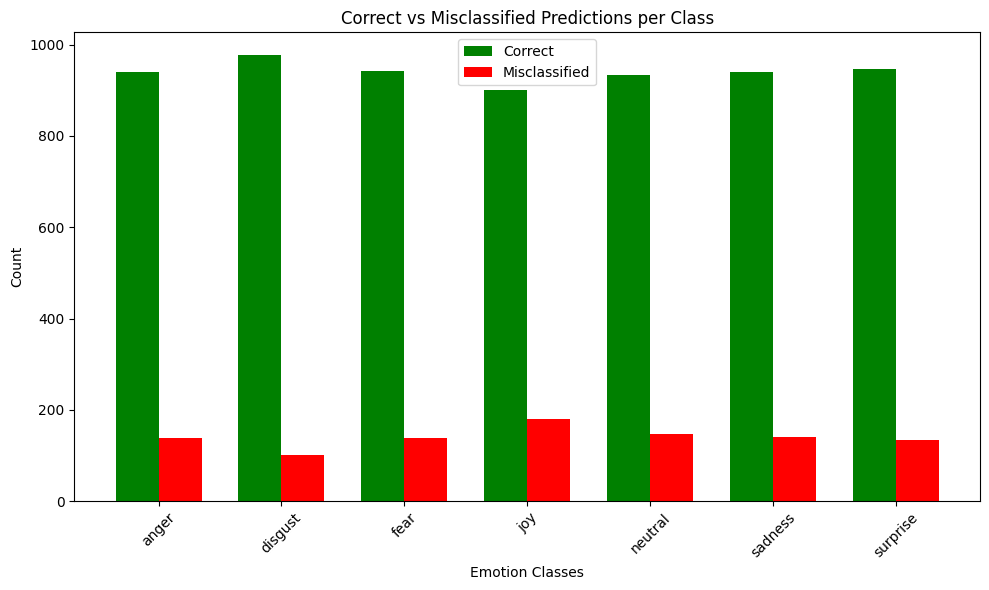

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as T
from torchvision.models import resnet18
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("/content/train_sent_emo.csv")
df = df.dropna(subset=['File_Path'])
df = df[df['File_Path'].apply(lambda x: os.path.isdir(x))]
min_count = df['Emotion'].value_counts().min()
balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
balanced_df.to_csv("/content/balanced_sent_emo.csv", index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True).to(device)
model.eval()
extractor = torch.nn.Sequential(*list(model.children())[:-1])

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_frame_features(folder, num_frames=5):
    features = []
    frames = sorted(os.listdir(folder))[:num_frames]
    for f in frames:
        path = os.path.join(folder, f)
        image = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = extractor(image).squeeze().cpu()
            features.append(feat)
    if features:
        return torch.stack(features)
    else:
        return torch.zeros((num_frames, 512))

emotion_map = {emo: i for i, emo in enumerate(balanced_df['Emotion'].unique())}

class FrameLSTMDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        feature_seq = extract_frame_features(row['File_Path'])  # [seq_len, feature_dim]
        label = emotion_map[row['Emotion']]
        return feature_seq, torch.tensor(label)

# === MODEL: LSTM + ATTENTION ===
class EmotionLSTMAttn(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, num_layers=1, num_classes=7):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch, seq_len, hidden]
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, hidden]
        out = self.fc(context)  # [batch, num_classes]
        return out

# === COLLATE FUNCTION ===
def collate_fn(batch):
    features = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    return features_padded, labels

# === TRAINING SETUP ===
dataset = FrameLSTMDataset(balanced_df)
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model = EmotionLSTMAttn().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# === TRACKING PREDICTIONS ===
all_preds = []
all_labels = []

correct_counts = {i: 0 for i in range(len(emotion_map))}
misclassified_counts = {i: 0 for i in range(len(emotion_map))}

# === TRAINING LOOP ===
for epoch in range(30):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples += y.size(0)
        correct_predictions += (predicted == y).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        # Update counts for correct and misclassified predictions
        for true, pred in zip(y.cpu().numpy(), predicted.cpu().numpy()):
            if true == pred:
                correct_counts[true] += 1
            else:
                misclassified_counts[true] += 1

    epoch_loss = total_loss / len(loader)
    accuracy = 100 * correct_predictions / total_samples
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# === Plotting the Misclassification Bar Graph ===
correct_values = [correct_counts[i] for i in range(len(emotion_map))]
misclassified_values = [misclassified_counts[i] for i in range(len(emotion_map))]

# Plot the bar graph
labels = list(emotion_map.keys())
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.35
plt.bar(x - bar_width/2, correct_values, bar_width, label='Correct', color='g')
plt.bar(x + bar_width/2, misclassified_values, bar_width, label='Misclassified', color='r')

plt.xlabel('Emotion Classes')
plt.ylabel('Count')
plt.title('Correct vs Misclassified Predictions per Class')
plt.xticks(x, labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


for testing video

In [ ]:
# Example: Test on a new video folder
test_video_path = '/content/drive/MyDrive/MELD.Raw/train/frames/dia1001_utt5'

# Extract features from the frames of the new video
test_features = extract_frame_features(test_video_path, num_frames=5)

# Pass the extracted features through the model
model.eval()
test_features = test_features.unsqueeze(0).to(device)  # Add batch dimension
output = model(test_features)

# Get the predicted emotion
predicted_class = torch.argmax(output, dim=1).item()

# Map the predicted class to its emotion label
predicted_emotion = list(emotion_map.keys())[predicted_class]
print(f'Predicted Emotion: {predicted_emotion}')


Predicted Emotion: 3


concating both results

<ipython-input-4-09c48ab16341>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1

Epoch 1 | Loss: 1.9646 | Accuracy: 13.10%


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Epoch 2 | Loss: 1.8503 | Accuracy: 31.35%


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


Epoch 3 | Loss: 1.6685 | Accuracy: 45.24%


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Epoch 4 | Loss: 1.5156 | Accuracy: 56.35%


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Epoch 5 | Loss: 1.3254 | Accuracy: 66.27%


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch 6 | Loss: 1.1139 | Accuracy: 79.76%


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


Epoch 7 | Loss: 0.9085 | Accuracy: 86.90%


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Epoch 8 | Loss: 0.6926 | Accuracy: 93.25%


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch 9 | Loss: 0.5169 | Accuracy: 94.44%


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch 10 | Loss: 0.3911 | Accuracy: 98.02%


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch 11 | Loss: 0.2873 | Accuracy: 98.02%


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


Epoch 12 | Loss: 0.2076 | Accuracy: 98.81%


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


Epoch 13 | Loss: 0.1560 | Accuracy: 99.21%


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch 14 | Loss: 0.1231 | Accuracy: 99.21%


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


Epoch 15 | Loss: 0.1080 | Accuracy: 99.21%


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch 16 | Loss: 0.0870 | Accuracy: 99.21%


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


Epoch 17 | Loss: 0.0784 | Accuracy: 99.21%


100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


Epoch 18 | Loss: 0.0680 | Accuracy: 98.81%


100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


Epoch 19 | Loss: 0.0590 | Accuracy: 99.60%


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


Epoch 20 | Loss: 0.0553 | Accuracy: 99.21%


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch 21 | Loss: 0.0514 | Accuracy: 98.81%


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Epoch 22 | Loss: 0.0481 | Accuracy: 99.21%


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch 23 | Loss: 0.0435 | Accuracy: 99.21%


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


Epoch 24 | Loss: 0.0459 | Accuracy: 99.21%


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


Epoch 25 | Loss: 0.0430 | Accuracy: 98.81%


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


Epoch 26 | Loss: 0.0398 | Accuracy: 99.21%


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch 27 | Loss: 0.0347 | Accuracy: 99.60%


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Epoch 28 | Loss: 0.0327 | Accuracy: 99.60%


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Epoch 29 | Loss: 0.0344 | Accuracy: 98.81%


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


Epoch 30 | Loss: 0.0309 | Accuracy: 99.21%

📊 Classification Report:

              precision    recall  f1-score   support

       anger       0.87      0.89      0.88      1080
     disgust       0.83      0.82      0.83      1080
        fear       0.83      0.91      0.87      1080
         joy       0.93      0.85      0.89      1080
     neutral       0.87      0.95      0.91      1080
     sadness       0.93      0.87      0.90      1080
    surprise       0.93      0.89      0.91      1080

    accuracy                           0.88      7560
   macro avg       0.88      0.88      0.88      7560
weighted avg       0.88      0.88      0.88      7560



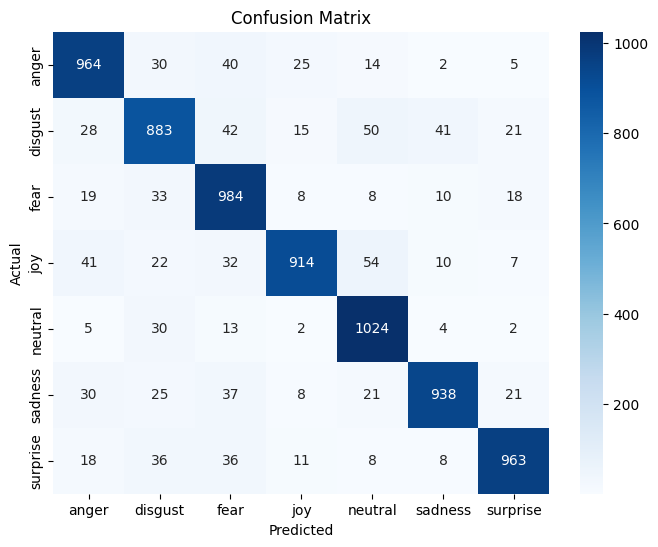

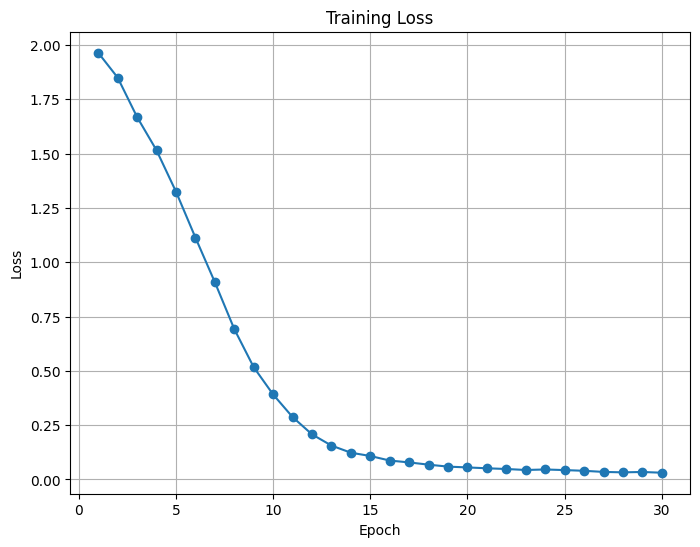

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


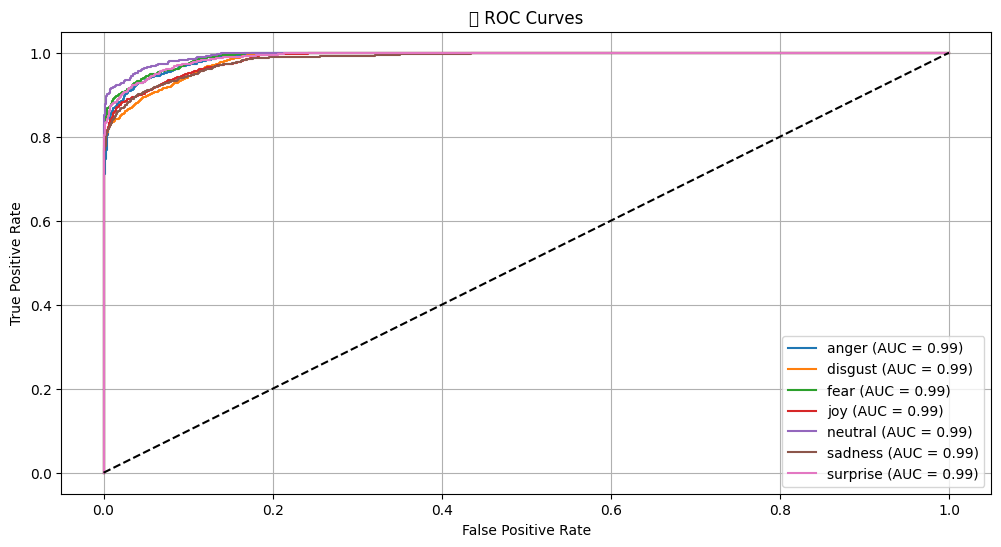

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


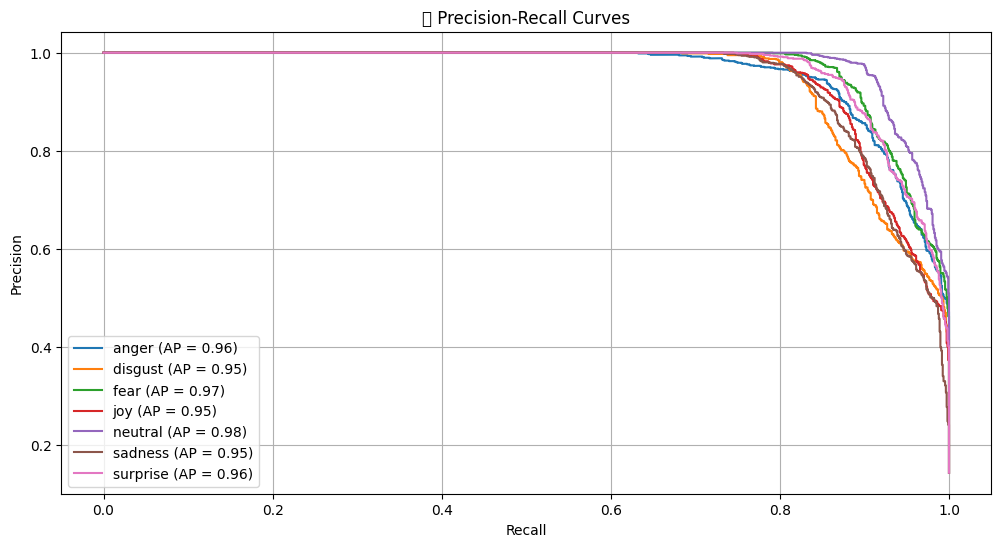

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision.models import resnet18
import torchvision.transforms as T
from transformers import BertTokenizer, BertModel
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and prepare data
df = pd.read_csv("/content/train_sent_emo.csv")
df = df.dropna(subset=['File_Path', 'Utterance', 'Emotion'])
df = df[df['File_Path'].apply(lambda x: os.path.isdir(x))]

min_count = df['Emotion'].value_counts().min()
balanced_df = df.groupby('Emotion').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
emotion_labels = sorted(balanced_df['Emotion'].unique())
emotion_map = {e: i for i, e in enumerate(emotion_labels)}

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
resnet = resnet18(pretrained=True).to(device).eval()
extractor = nn.Sequential(*list(resnet.children())[:-1])
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_frame_features(folder, num_frames=5):
    features = []
    frames = sorted(os.listdir(folder))[:num_frames]
    for f in frames:
        img_path = os.path.join(folder, f)
        image = transform(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = extractor(image).squeeze().cpu()
            features.append(feat)
    return torch.stack(features) if features else torch.zeros((num_frames, 512))

class MultimodalDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sentence = row['Utterance']
        folder = row['File_Path']
        label = emotion_map[row['Emotion']]

        encoded = tokenizer(sentence, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        frame_feats = extract_frame_features(folder)

        return input_ids, attention_mask, frame_feats, torch.tensor(label)

def collate_fn(batch):
    input_ids = torch.stack([x[0] for x in batch])
    attention_mask = torch.stack([x[1] for x in batch])
    frame_feats = pad_sequence([x[2] for x in batch], batch_first=True)
    labels = torch.tensor([x[3] for x in batch])
    return input_ids, attention_mask, frame_feats, labels

class FusionModel(nn.Module):
    def __init__(self, hidden_dim=256, lstm_layers=1, num_classes=7):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(512, hidden_dim, lstm_layers, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(768 + hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask, frame_feats):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_feat = bert_output.pooler_output
        lstm_out, _ = self.lstm(frame_feats.to(device))
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        fused = torch.cat((bert_feat, context), dim=1)
        output = self.fc(fused)
        return output

dataset = MultimodalDataset(balanced_df)
loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

model = FusionModel(num_classes=len(emotion_labels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

losses, all_preds, all_labels = [], [], []
all_probs = []

for epoch in range(30):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for input_ids, attention_mask, frame_feats, labels in tqdm(loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask, frame_feats)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().detach().numpy())

    avg_loss = total_loss / len(loader)
    acc = correct / total * 100
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")

# 📊 Classification report
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

# 📌 Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📉 Loss plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

# 🔍 ROC & Precision-Recall curves
y_true = label_binarize(all_labels, classes=list(range(len(emotion_labels))))
all_probs = np.array(all_probs)

# ROC Curves
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 6))
for i in range(len(emotion_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curves")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curves
precision = {}
recall = {}
avg_precision = {}

plt.figure(figsize=(12, 6))
for i in range(len(emotion_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true[:, i], all_probs[:, i])
    plt.plot(recall[i], precision[i], label=f"{emotion_labels[i]} (AP = {avg_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📉 Precision-Recall Curves")
plt.legend()
plt.grid()
plt.show()


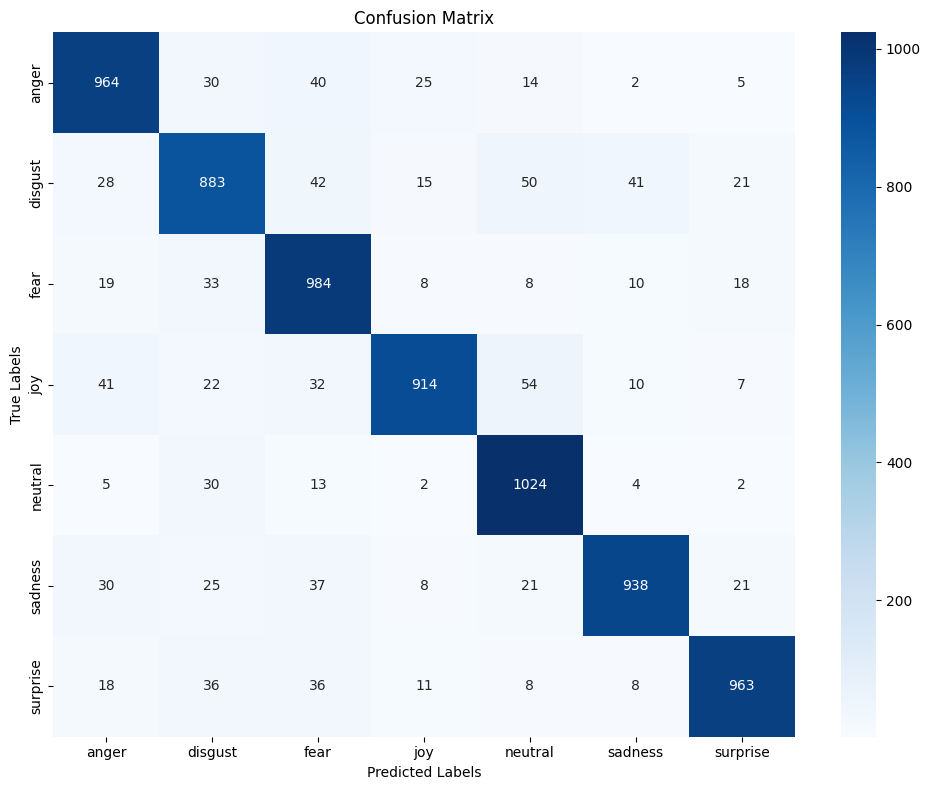

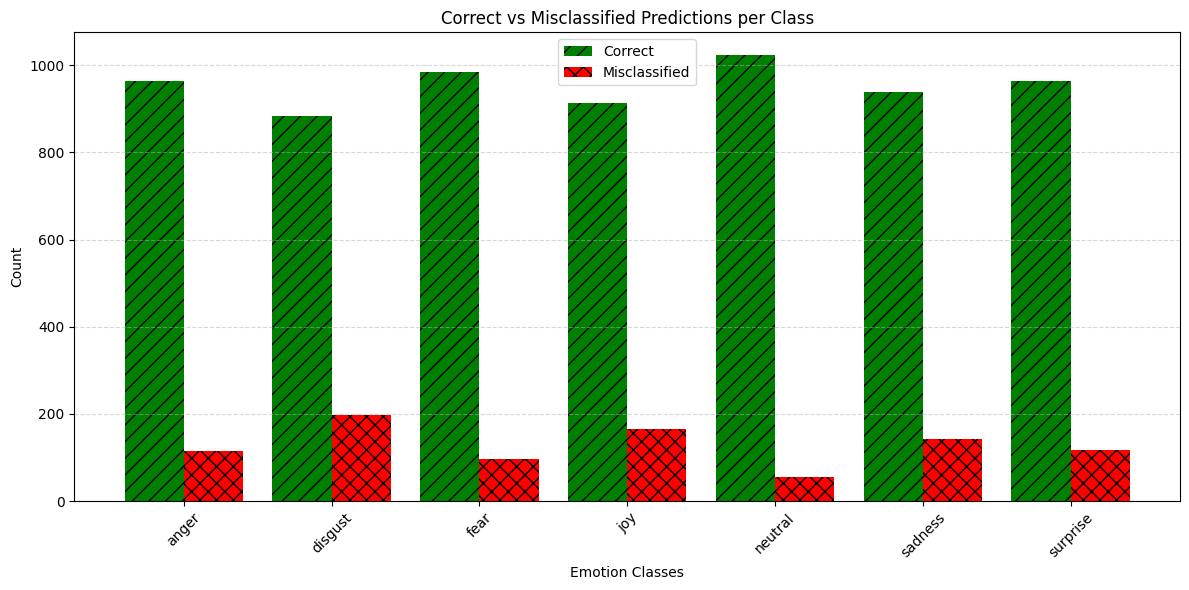

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming these are defined earlier in your code
# all_labels = [...], all_preds = [...]
# emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Convert predictions to numpy
all_labels = torch.tensor(all_labels).cpu().numpy()
all_preds = torch.tensor(all_preds).cpu().detach().numpy()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Correct vs Misclassified Counts
correct_counts = {emotion: 0 for emotion in emotion_labels}
misclassified_counts = {emotion: 0 for emotion in emotion_labels}

for true, pred in zip(all_labels, all_preds):
    emotion = emotion_labels[true]
    if true == pred:
        correct_counts[emotion] += 1
    else:
        misclassified_counts[emotion] += 1

# Bar Graph
x = np.arange(len(emotion_labels))
correct_vals = [correct_counts[e] for e in emotion_labels]
misclassified_vals = [misclassified_counts[e] for e in emotion_labels]

plt.figure(figsize=(12, 6))
bar_width = 0.4

plt.bar(x - bar_width/2, correct_vals, width=bar_width, label='Correct', color='green', hatch='//')
plt.bar(x + bar_width/2, misclassified_vals, width=bar_width, label='Misclassified', color='red', hatch='xx')

plt.xlabel("Emotion Classes")
plt.ylabel("Count")
plt.title("Correct vs Misclassified Predictions per Class")
plt.xticks(ticks=x, labels=emotion_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()